# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-valve fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%matplotlib inline

In [2]:
from IPython.core.debugger import set_trace

In [3]:
from demo import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [5]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 36.227
Epoch: 213


In [6]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [7]:
X, E, L, D = [param.cpu().detach().numpy() for param in params]
MSE = np.power((X - D), 2).sum() / 2
print(f"MSE of random data = {MSE:.3f}")

MSE of random data = 662.471


In [8]:
X[:, :4, :4]

array([[[0.06194194, 0.18859185, 0.2568104 , 0.02707508],
        [0.6023704 , 0.54795104, 0.3180737 , 0.4859855 ],
        [0.32365754, 0.30698073, 0.98534626, 0.14601523],
        [0.80166066, 0.37292635, 0.2047649 , 0.4268695 ]]], dtype=float32)

In [9]:
D[:, :4, :4]

array([[[ 0.34211573,  0.08798303,  0.21496692,  0.28273338],
        [ 0.16703121, -0.09991661, -0.2242749 , -0.04380743],
        [ 0.54004323,  0.30919513,  0.23557197,  0.36347508],
        [ 0.34255916,  0.26711488,  0.36786947,  0.5222602 ]]],
      dtype=float32)

Next we need to load the datasets of sensors readings.

In [10]:
data_path = Path('data/hydraulic')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [11]:
print(len(train_dl), len(val_dl), len(test_dl))

38 10 720


Let's get some random samples from the dataset for examples and generate new versions.

In [12]:
data, targets = get_random_samples(test_dl)

In [13]:
list_target_classes(test_dl)

0 = fail
1 = norm


In [14]:
targets = targets.cpu().numpy()
targets

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0])

In [15]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [16]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [17]:
gen_err = -loss_desc['logp']
gen_err

tensor([ 22.8743,   9.3572,   5.8993,   5.2420,   5.7047,   2.6080,  14.6190,
        101.4112,   3.3941,   1.1929,   3.5892,   6.4618,   8.8150,   5.2004,
          2.3492,  17.9804,   5.3987,   8.0374,   3.8540,   9.2530],
       device='cuda:0')

[[-0.04773094 -0.03744501 -0.01997909 -0.05849271 -0.06125692]
 [-0.02556621 -0.01149274  0.01245918  0.02447466 -0.00270598]
 [-0.17492037 -0.03458502  0.02234292 -0.04566709 -0.04618954]
 [-0.05393696 -0.01938412 -0.04137784  0.02342206  0.03995657]
 [ 0.02112377 -0.08767301 -0.02100736 -0.00076904 -0.01578264]]
MSE = 22.874319076538086


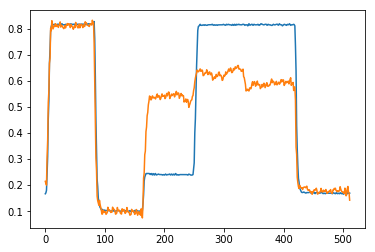

In [18]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[-0.04607233 -0.04121712 -0.00186057 -0.07702681 -0.0149872 ]
 [-0.0205321  -0.01183975  0.0078085   0.0239295  -0.00350988]
 [-0.09557384  0.02919871  0.05576754  0.00288634  0.03115252]
 [-0.03100425  0.00996092 -0.01073718  0.05575496  0.07845682]
 [ 0.03393123 -0.06238171 -0.01426594  0.00139033 -0.01859334]]
MSE = 9.357234954833984


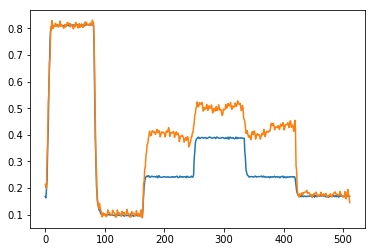

In [19]:
idx = 1
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [20]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, MSE = {err[i]:.3f}")

Target = 1, MSE = 22.874
Target = 1, MSE = 9.357
Target = 0, MSE = 5.899
Target = 1, MSE = 5.242
Target = 1, MSE = 5.705
Target = 0, MSE = 2.608
Target = 1, MSE = 14.619
Target = 0, MSE = 101.411
Target = 1, MSE = 3.394
Target = 1, MSE = 1.193
Target = 0, MSE = 3.589
Target = 0, MSE = 6.462
Target = 1, MSE = 8.815
Target = 1, MSE = 5.200
Target = 1, MSE = 2.349
Target = 0, MSE = 17.980
Target = 1, MSE = 5.399
Target = 0, MSE = 8.037
Target = 1, MSE = 3.854
Target = 0, MSE = 9.253


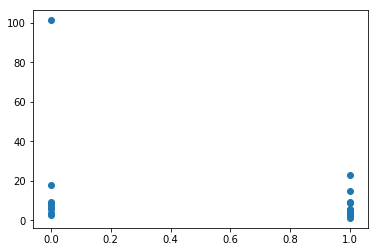

In [21]:
plt.scatter(targets, err)

Show the data plots.

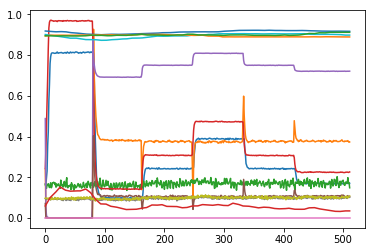

In [22]:
show_plot(sample)

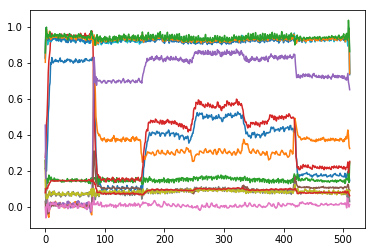

In [23]:
show_plot(gen_sample)

Let's score the success of the recreation and look for outliers.

In [202]:
def compute_scores(X, model, criterion):
    assert X.shape[0] == 1, "Must compute score for one sample at a time"
    X_hat, mu, logvar = model(X)
    loss, loss_desc = criterion(X_hat, X, mu, logvar, reduce=False)
    score = {'loss': loss.item(),
             'KL': loss_desc['KL'].item(),
             'error': -loss_desc['logp'].item()}
    return score

def score(dl):
    score_names = ['loss', 'KL', 'error']
    classes = dl.dataset.classes
    scores = {(name, cls): [] for name in score_names for cls in classes}
    
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(tqdm(dl)):
            X = X.to(device)
            for j in range(X.shape[0]):
                data = X[j, :].unsqueeze(0)
                cls = classes[y[j].item()]
                score = compute_scores(data, model, criterion)
                for name in score_names:
                    scores[(name, cls)].append(score[name])
    return scores

In [212]:
scores = score(test_dl)


100%|██████████| 720/720 [00:05<00:00, 142.91it/s]

In [26]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

###################### TEST MEANS #####################
            fail       norm
loss   29.852517  27.609689
KL     20.251951  20.298295
error   9.600565   7.311393


In [27]:
val_means = pd.DataFrame()
for (name, cls), item in score(val_dl).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

100%|██████████| 10/10 [00:01<00:00,  5.23it/s]

###################### VAL MEANS #####################
            norm
loss   26.481654
KL     19.929087
error   6.552568


In [28]:
train_means = pd.DataFrame()
for (name, cls), item in score(train_dl).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(train_means)

100%|██████████| 38/38 [00:06<00:00,  5.91it/s]

###################### VAL MEANS #####################
            norm
loss   27.690399
KL     21.154103
error   6.536296


Let's calculate AUC to judge performance.

In [183]:
scores.keys()

dict_keys([('loss', 'fail'), ('loss', 'norm'), ('KL', 'fail'), ('KL', 'norm'), ('error', 'fail'), ('error', 'norm')])

In [255]:
print(len(scores[('error', 'fail')]), len(scores[('error', 'fail')]))

360 360


In [256]:
def auc_score(dl, scores=None):
    if scores == None:
        scores = score(dl)
    score_name = 'error'
    classes = dl.dataset.classes
    y_true = []
    y_score = []
    for i, cls in enumerate(classes):
        cls_score = scores[(score_name, cls)]
        y_true.extend([i] * len(cls_score))
        y_score.extend(cls_score)
    return roc_auc_score(y_true, y_score)

In [257]:
# simple definition of the threshold
threshold = (np.mean(scores['error', 'fail']) +
             np.mean(scores['error', 'norm'])) / 2
threshold

8.455979267756145

In [258]:
# logistic regression threshold
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
y_score = []
y_score.extend(scores[('error', 'fail')])
y_true = [0] * len(y_score)
y_score.extend(scores[('error', 'norm')])
y_true.extend([1] * (len(y_score) - len(y_true)))
y_score = np.array(y_score)[:, None]
y_true = np.array(y_true)
logreg.fit(y_score, y_true);

In [259]:
weight = float(logreg.coef_)
print('Weight: ', weight)

Weight:  -0.010827467233385351


In [260]:
intercept = float(logreg.intercept_)
print('Intercept: ', intercept)

Intercept:  0.08934981908122977


In [261]:
# Decision boundary P = 0.5
logreg_threshold = - intercept / weight
logreg_threshold

8.252144029189859

In [266]:
r_scores = logreg.predict(y_score)
r_scores[:100]

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1])

In [230]:
y_corr = r_scores == y_true

In [231]:
y_corr.sum() / len(y_corr)

0.5111111111111111

In [268]:
t_scores = scores.copy()
t_scores[('error', 'fail')] = ~(t_scores[('error', 'fail')] >= threshold)
t_scores[('error', 'norm')] = ~(t_scores[('error', 'norm')] < threshold)
t_score = []
t_score.extend(t_scores[('error', 'fail')])
t_score.extend(t_scores[('error', 'norm')])

In [272]:
threshold

8.455979267756145

In [270]:
t_corr = t_score == y_true

In [273]:
t_corr.sum() / len(t_corr)

0.18888888888888888

In [274]:
auc_scores = auc_score(test_dl, t_scores)
auc_scores

0.18888888888888888

In [275]:
np.mean(scores['error', 'norm'])

7.311393107308282

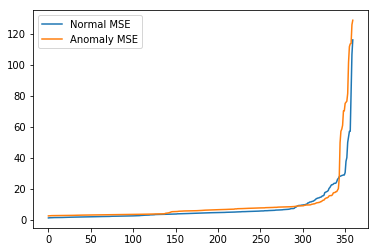

In [276]:
normaly = sorted(scores[('error', 'norm')])
anomaly = sorted(scores[('error', 'fail')])
plt.plot(normal, label='Normal MSE')
plt.plot(anomaly, label='Anomaly MSE')
plt.legend()

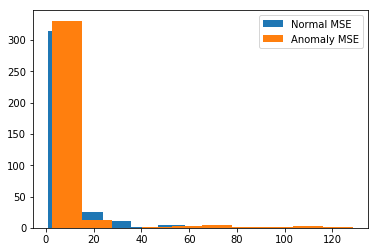

In [87]:
plt.hist(normaly, label='Normal MSE')
plt.hist(anomaly, label='Anomaly MSE')
plt.legend()

In [88]:
normalx = np.random.rand(len(normaly))
anomalx = np.random.rand(len(anomaly))

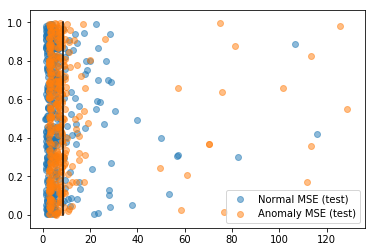

In [277]:
plt.scatter(normaly, normalx, label='Normal MSE (test)', alpha=0.5)
plt.scatter(anomaly, anomalx, label='Anomaly MSE (test)', alpha=0.5)
plt.plot([threshold, threshold], [0, 1], 'k-')
plt.legend()

Try fitting a normal distribution to the validation MSE to define a threshold.

In [56]:
val_scores = score(val_dl)

100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


In [58]:
val_scores.keys()

dict_keys([('loss', 'norm'), ('KL', 'norm'), ('error', 'norm')])

[1.0115026235580444, 1.0274932384490967, 1.0720715522766113, 1.1668403148651123, 1.1849758625030518]
mean=6.55, stdev=8.45


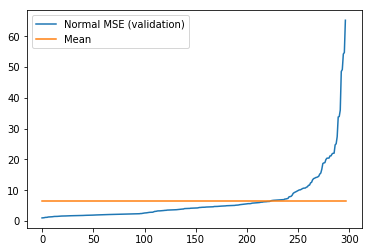

In [114]:
val_norm = sorted(val_scores[('error', 'norm')])
print(val_norm[:5])
mean = np.mean(val_norm)
std = np.std(val_norm)
print('mean={:.2f}, stdev={:.2f}'.format(mean, std))
plt.plot(val_norm, label= 'Normal MSE (validation)')
plt.plot([0, len(val_norm)], [mean, mean], label='Mean')
plt.legend()

Implement PCA to visualize the latent space.

In [294]:
def compute_mu(dl):
    latents = []
    targets = []
    
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(tqdm(dl)):
            X = X.to(device)
            for j in range(X.shape[0]):
                data = X[j, :].unsqueeze(0)
                X_hat, mu, logvar = model(data)
                
                latents.append(mu.cpu().detach().numpy())
                targets.append(y[j].item())
    
    latents = np.array(latents).reshape(len(latents), -1)
    targets = np.array(targets)
    return latents, targets

In [295]:
latents, targets = compute_mu(test_dl)


100%|██████████| 720/720 [00:04<00:00, 149.37it/s]

In [284]:
from sklearn.decomposition import PCA

In [318]:
pca = PCA(n_components=2)

In [319]:
lat_pca = pca.fit_transform(latents)

In [320]:
lat_pca.shape

(720, 2)

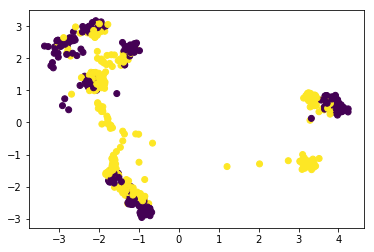

In [321]:
plt.scatter(lat_pca[:, 0], lat_pca[:, 1], c=targets)

In [322]:
pca.explained_variance_ratio_

array([0.4421441 , 0.21820441], dtype=float32)

Cluster the latent space into kmeans clusters.

In [323]:
from sklearn.cluster import KMeans

In [324]:
kmeans = KMeans(2)

In [325]:
lat_k = kmeans.fit_transform(latents)

In [326]:
lat_k.shape

(720, 2)

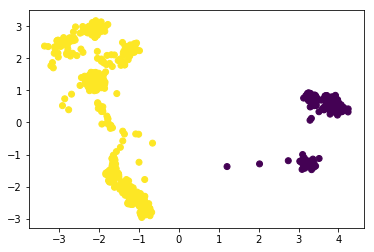

In [327]:
plt.scatter(lat_pca[:, 0], lat_pca[:, 1], c=kmeans.labels_)

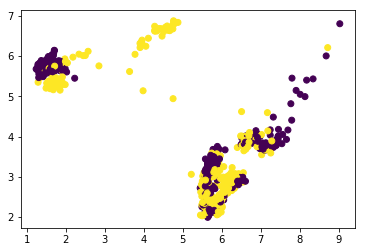

In [329]:
plt.scatter(lat_k[:, 0], lat_k[:, 1], c=targets)